<a href="https://colab.research.google.com/github/JhonAlG/Research-Test/blob/main/SMT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aacgmv2 apexpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.1/341.1 kB 23.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for aacgmv2: filename=aacgmv2-2.7.0-cp311-cp311-linux_x86_64.whl size=1705433 sha256=3d17299cb560774b87ba52b50ca811bb143f9334ed00d653832b7df1d0bb9e9d
  Stored in directory: /root/.cache/pip/wheels/45/12/50/7165f90f0ccd50e1e05f206092f81a60bd4e53ae6928a99653
  Created wheel for apexpy: filename=apexpy-2.1.0-cp311-cp311-linux_x86_64.whl size=293970 sha256=a2de12ce4f25feb2b99407d396c178d1db0da50b0493fe71dfa49c6dcd89868a
  Stored in directory: /root/.cache/pip/wheels/74/8d/de/f5c2e03373d5d855a91f6818ad9dfa78b3d

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import aacgmv2
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
from apexpy import Apex

Import necessary libraries for access to functions/tools

In [2]:
aurora_df = pd.read_csv(
    "https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/Code/2015_web_observations_cleaned.csv",
    encoding='latin1',
    on_bad_lines='skip'
)
print("Aurora DF columns:", aurora_df.columns.tolist())

# Validate required columns
required_cols = ['st_y', 'st_x', 'time_start']
if not all(col in aurora_df.columns for col in required_cols):
    raise ValueError(f"Missing required columns: {set(required_cols) - set(aurora_df.columns)}")

# Set timestamp column and reference time
timestamp_col = 'time_start'
ref_time = datetime(2015, 3, 18, 2, 0, 0)

# Convert Aurorasaurus coordinates using ApexPy
latitudes = aurora_df['st_y'].astype(float)
longitudes = aurora_df['st_x'].astype(float)
apex = Apex(ref_time)
mlat, mlt = apex.convert(
    lat=latitudes.to_numpy(),
    lon=longitudes.to_numpy(),
    height=110,
    source='geo',
    dest='mlt',
    datetime=ref_time
)
aurora_df['MLT'] = mlt
aurora_df['ML'] = mlat
aurora_df = aurora_df.dropna(subset=['MLT', 'ML'])
print(f"Number of Aurorasaurus reports after conversion: {len(aurora_df)}")

Aurora DF columns: ['id', 'activities_id', 'height_id', 'sky_id', 'observer_id', 'timestamp', 'address_country', 'address_state', 'location', 'see_aurora', 'sky_other', 'time_start', 'time_end', 'on_going', 'height_other', 'activities_other', 'colors_other', 'types_other', 'comment', 'image', 'st_y', 'st_x', 'colors', 'types']
Number of Aurorasaurus reports after conversion: 1346


In [3]:
# Load the eflux data
eflux_url = "https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/Eflux/20150318_0200UT_Eflux_e%2Call.txt"
df_eflux = pd.read_csv(
    eflux_url,
    header=None,
    skiprows=1,
    nrows=7680,
    sep='\s+',
    on_bad_lines='skip'
)
df_eflux.columns = ["MLT", "ML", "[mW m^-2]"]

# Prepare features and target
X = df_eflux[["MLT", "ML"]].values
y_flux = df_eflux["[mW m^-2]"].values
FLUX_THRESHOLD = 0.5  # Parameterized threshold
y_binary = (y_flux > FLUX_THRESHOLD).astype(int)

# Check for NaN values
if np.any(np.isnan(X)) or np.any(np.isnan(y_flux)):
    raise ValueError("Input data contains NaN values")

# Scale and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)
X_train_orig = scaler.inverse_transform(X_train)
X_test_orig = scaler.inverse_transform(X_test)


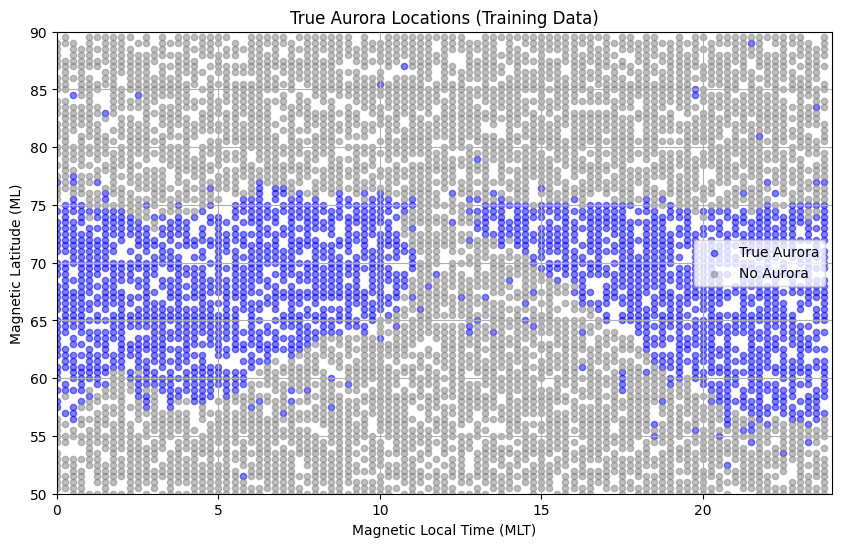

In [4]:
# Plot Actual Aurora Location
plt.figure(figsize=(10, 6))
plt.scatter(X_train_orig[y_train == 1, 0], X_train_orig[y_train == 1, 1], c='blue', label='True Aurora', alpha=0.5, s=20)
plt.scatter(X_train_orig[y_train == 0, 0], X_train_orig[y_train == 0, 1], c='gray', label='No Aurora', alpha=0.5, s=20)
plt.xlabel('Magnetic Local Time (MLT)')
plt.ylabel('Magnetic Latitude (ML)')
plt.title('True Aurora Locations (Training Data)')
plt.legend()
plt.grid(True)
plt.xlim(0, 24)
plt.ylim(50, 90)
plt.show()

In [5]:
# Build and Train Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, verbose=True)

Epoch 1/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5070 - loss: 0.6963 - val_accuracy: 0.7006 - val_loss: 0.5534
Epoch 2/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6868 - loss: 0.5365 - val_accuracy: 0.7274 - val_loss: 0.4543
Epoch 3/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7637 - loss: 0.4343 - val_accuracy: 0.8771 - val_loss: 0.3460
Epoch 4/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8877 - loss: 0.3267 - val_accuracy: 0.8967 - val_loss: 0.2829
Epoch 5/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8847 - loss: 0.2760 - val_accuracy: 0.9015 - val_loss: 0.2538
Epoch 6/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8937 - loss: 0.2427 - val_accuracy: 0.8991 - val_loss: 0.2413
Epoch 7/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9026 - loss: 0.2257 - val_accuracy: 0.8975 - val_loss: 0.2331
Epoch 8/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.2225 - val_accu

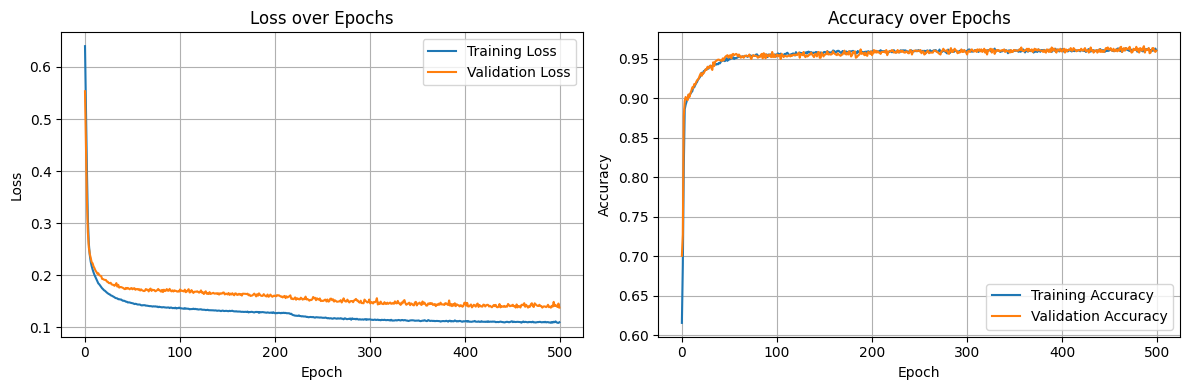

Test Accuracy: 0.9616
Final Validation Accuracy: 0.9601


In [7]:
# Plot Model Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [8]:
#Predictions
y_pred_percent_test = model.predict(X_test).flatten() * 100

#convert MLT/ML
#def convert_to_mlt_mlat(lat, lon, tstr):
#    try:
#        ts = pd.to_datetime(tstr).to_pydatetime()
#        mlat, mlt, _ = aacgmv2.get_aacgm_coord(lat, lon, 100, ts)
#        return pd.Series([mlt, mlat])
#    except Exception as e:
#        print(f"Conversion error for {tstr}: {e}")
#        return pd.Series([np.nan, np.nan])
#
#aurora_df[['MLT', 'ML']] = aurora_df.apply(
#    lambda r: convert_to_mlt_mlat(r['st_y'], r['st_x'], r[timestamp_col]), axis=1
#)
#aurora_df.dropna(subset=['MLT', 'ML'], inplace=True)

# Scale Aurorasaurus coordinates to match model input
#aurora_X = scaler.transform(aurora_df[['MLT', 'ML']].values)
#aurora_X_orig = scaler.inverse_transform(aurora_X)
#aurora_df['MLT'] = aurora_X_orig[:, 0]
#aurora_df['ML'] = aurora_X_orig[:, 1]


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


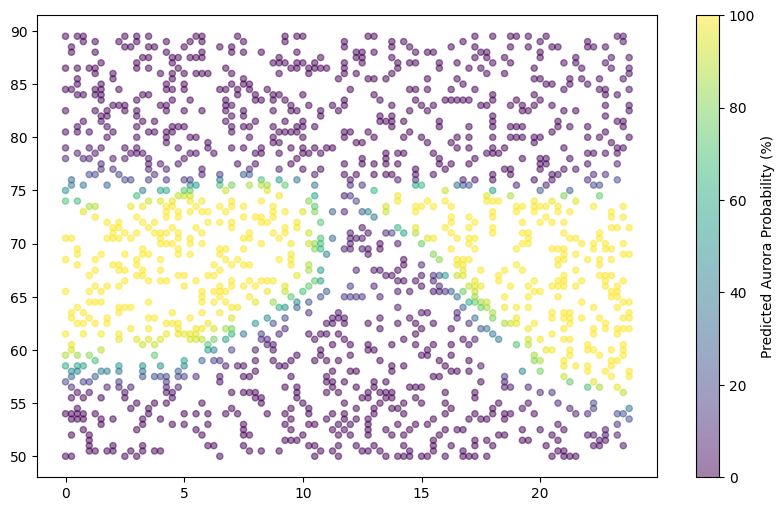

In [9]:
####NEW
# Plot Predicted Aurora Probability with Aurorasaurus Reports
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_test_orig[:, 0], X_test_orig[:, 1],
    c=y_pred_percent_test, cmap='viridis',
    alpha=0.5, s=20, vmin=0, vmax=100, label='Model Prediction'
)
plt.colorbar(scatter, label='Predicted Aurora Probability (%)')

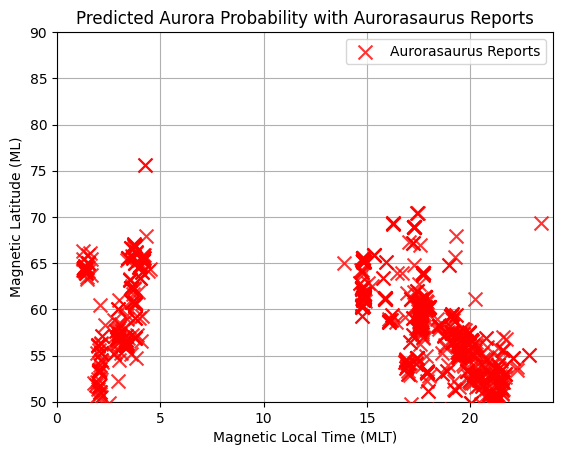

In [10]:
####NEW
# Plot Aurorasaurus reports (unscaled magnetic coordinates)
plt.scatter(
    aurora_df['MLT'], aurora_df['ML'],
    c='red', marker='x', label='Aurorasaurus Reports', alpha=0.8, s=100, zorder=10
)

plt.xlabel('Magnetic Local Time (MLT)')
plt.ylabel('Magnetic Latitude (ML)')
plt.title('Predicted Aurora Probability with Aurorasaurus Reports')
plt.legend()
plt.xlim(0, 24)
plt.ylim(50, 90)
plt.grid(True)
plt.show()

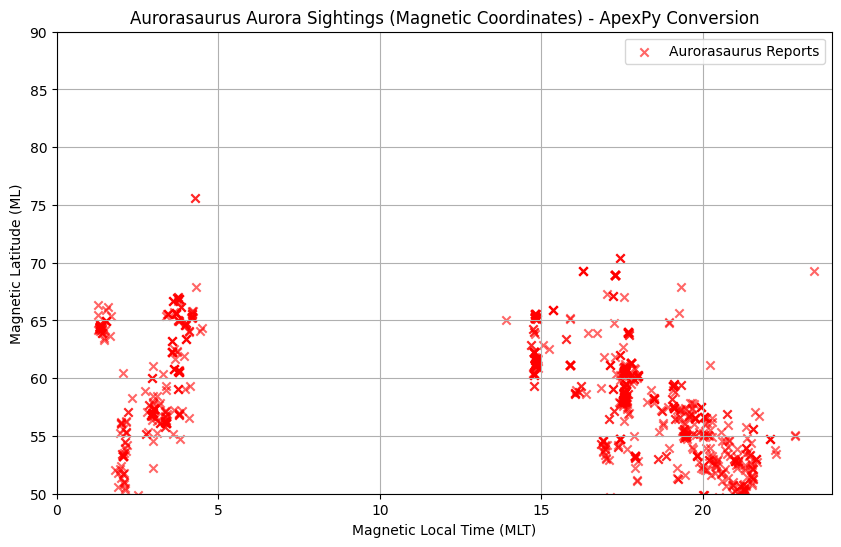

In [11]:
####NEW

# Plot Aurorasaurus points converted by ApexPy (for comparison)
plt.figure(figsize=(10, 6))
plt.scatter(aurora_df['MLT'], aurora_df['ML'], color='red', alpha=0.6, label='Aurorasaurus Reports', marker='x')
plt.xlabel('Magnetic Local Time (MLT)')
plt.ylabel('Magnetic Latitude (ML)')
plt.title('Aurorasaurus Aurora Sightings (Magnetic Coordinates) - ApexPy Conversion')
plt.grid(True)
plt.xlim(0, 24)
plt.ylim(50, 90)
plt.legend()
plt.show()


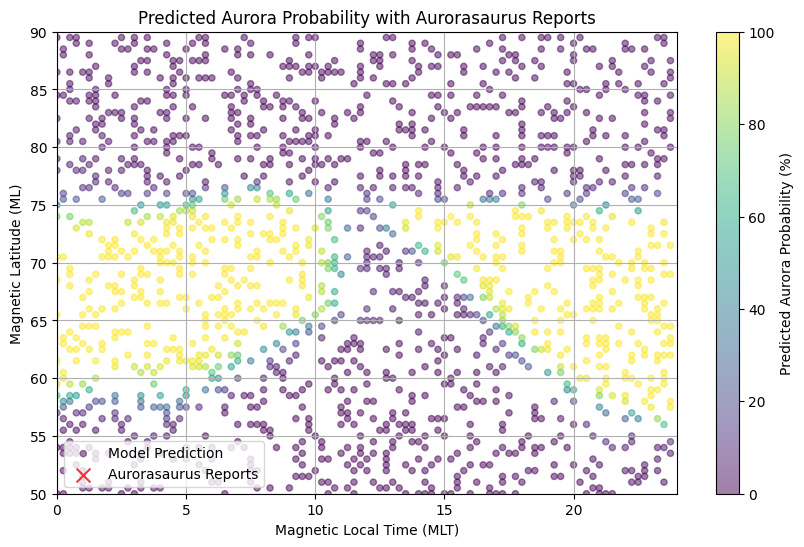

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_test_orig[:, 0], X_test_orig[:, 1],
    c=y_pred_percent_test, cmap='viridis',
    alpha=0.5, s=20, vmin=0, vmax=100, label='Model Prediction'
)
plt.colorbar(scatter, label='Predicted Aurora Probability (%)')

plt.scatter(
    aurora_df['MLT'], aurora_df['ML'],
    c='red', marker='x', label='Aurorasaurus Reports', alpha=0.8, s=100, zorder=10
)

plt.xlabel('Magnetic Local Time (MLT)')
plt.ylabel('Magnetic Latitude (ML)')
plt.title('Predicted Aurora Probability with Aurorasaurus Reports')
plt.legend()
plt.xlim(0, 24)  # Set MLT range
plt.ylim(50, 90)  # Set MLat range
plt.grid(True)
plt.show()

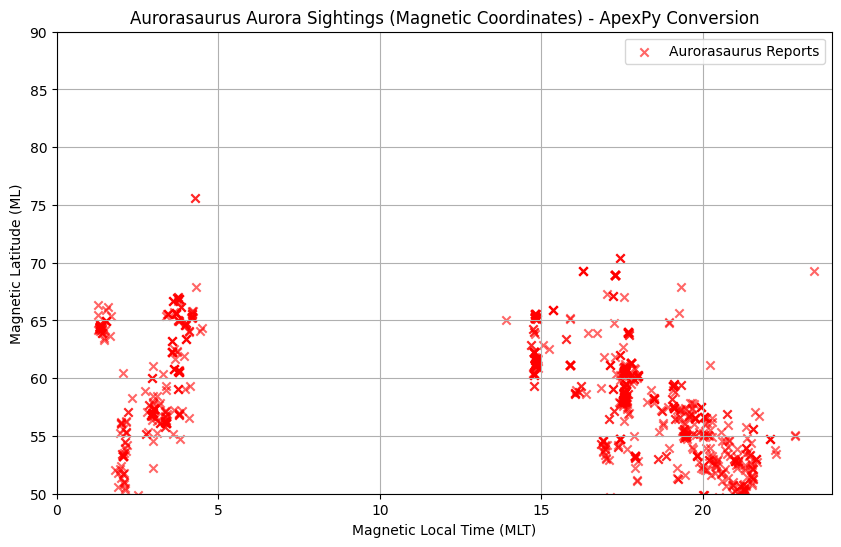

In [ ]:
aurora_df_apex = pd.read_csv(
    "https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/Code/2015_web_observations_cleaned.csv",
    encoding='latin1',
    on_bad_lines='skip'
)

# Extract lat/lon and convert to float
latitudes = aurora_df_apex['st_y'].astype(float)
longitudes = aurora_df_apex['st_x'].astype(float)

# Reference time same as your model data
ref_time = datetime(2015, 3, 18, 2, 0, 0)
apex = Apex(ref_time)

# Convert coordinates to Magnetic Latitude and Magnetic Local Time with datetime param
mlat, mlt = apex.convert(
    lat=latitudes.to_numpy(),
    lon=longitudes.to_numpy(),
    height=110,
    source='geo',
    dest='mlt',
    datetime=ref_time
)

# Plot Aurorasaurus points converted by ApexPy
plt.figure(figsize=(10, 6))
plt.scatter(mlt, mlat, color='red', alpha=0.6, label='Aurorasaurus Reports', marker='x')
plt.xlabel('Magnetic Local Time (MLT)')
plt.ylabel('Magnetic Latitude (ML)')
plt.title('Aurorasaurus Aurora Sightings (Magnetic Coordinates) - ApexPy Conversion')
plt.grid(True)
plt.xlim(0, 24)
plt.ylim(50, 90)
plt.legend()
plt.show()